# Chapter 7

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np


import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [4]:
import brfss


df = brfss.ReadBrfss(nrows=None)

c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.age.replace([7, 9], float('NaN'), inplace=True)
c:\Users\champ\OneDrive\Documents\DSC530 Data Exploration\ThinkStats2\code\brfss.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

The following function selects a random subset of a `DataFrame`.

In [5]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [6]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

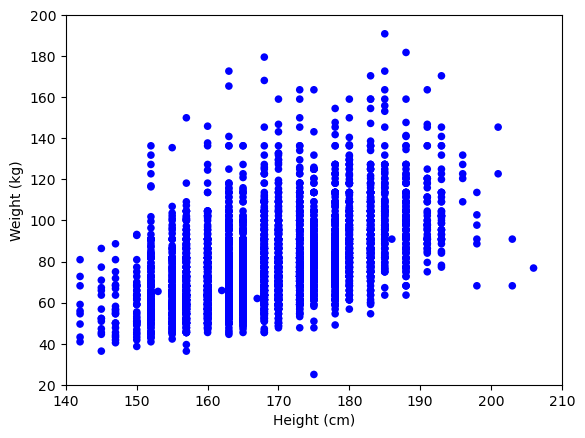

In [7]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noise to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [8]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.6 cm, so I'll add random values from -1.3 to 1.3.

In [9]:
heights = Jitter(heights, 1.3)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

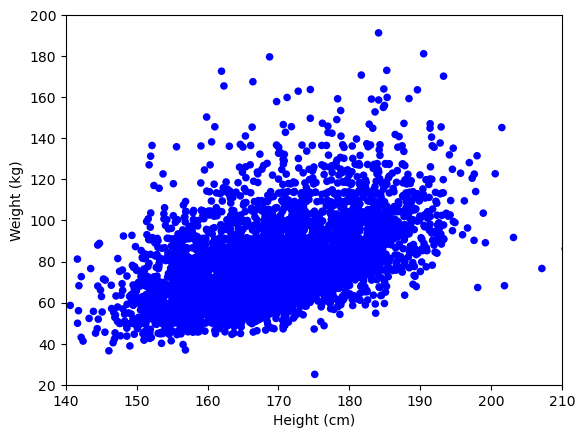

In [10]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

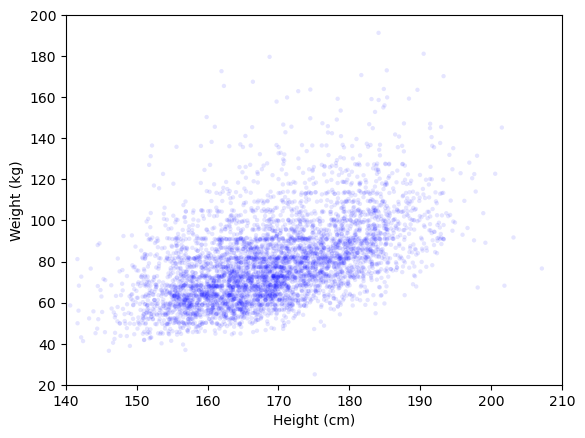

In [11]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

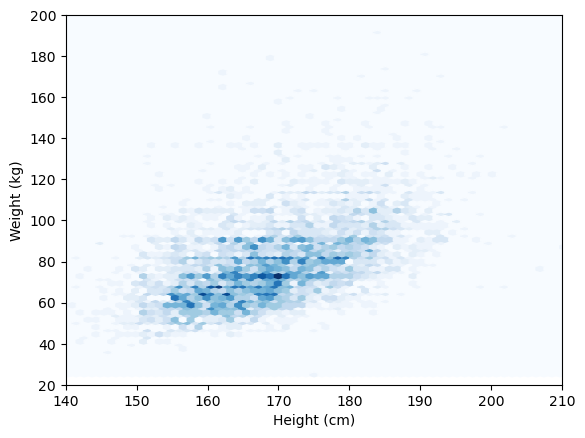

In [12]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [13]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [14]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [15]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [16]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

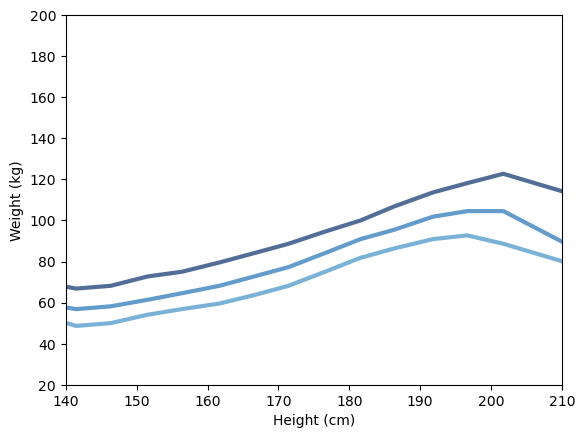

In [17]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [18]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [19]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697766

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [20]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [21]:
Corr(heights, weights)

0.5087364789734591

NumPy provides a function that computes correlations, too:

In [22]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [23]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [24]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [25]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [26]:
SpearmanCorr(heights, weights)

0.5405846262320491

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [27]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983429

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [28]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [ ]:
import first
import matplotlib.pyplot as plt

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

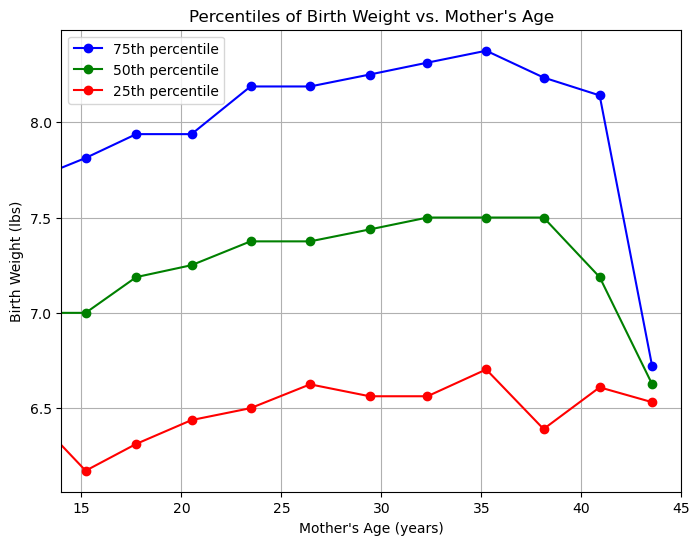

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def BinnedPercentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin."""
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df['agepreg'], bins)
    groups = df.groupby(indices)
    ages = []
    percentiles_25 = []
    percentiles_50 = []
    percentiles_75 = []
    for index, group in groups:
        if len(group) > 0:
            ages.append(group['agepreg'].mean())
            cdf = np.percentile(group['totalwgt_lb'], [25, 50, 75])
            percentiles_25.append(cdf[0])
            percentiles_50.append(cdf[1])
            percentiles_75.append(cdf[2])
    plt.figure(figsize=(8, 6))
    plt.plot(ages, percentiles_75, label='75th percentile', color='blue', marker='o')
    plt.plot(ages, percentiles_50, label='50th percentile', color='green', marker='o')
    plt.plot(ages, percentiles_25, label='25th percentile', color='red', marker='o')
    plt.title("Percentiles of Birth Weight vs. Mother's Age")
    plt.xlabel("Mother's Age (years)")
    plt.ylabel("Birth Weight (lbs)")
    plt.legend()
    plt.grid(True)
    plt.xlim([14, 45]) 
    plt.show()
BinnedPercentiles(live)


In [41]:
import scipy.stats as stats
correlation, p_value = stats.pearsonr(live['agepreg'], live['totalwgt_lb'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.0688339703541091
P-value: 5.722947107314431e-11


Pearson's coefficient indicates that there is a very low correlation between pregnancy age and baby weight. It is statistically significant, but the effect is not significant. It's a weak relationship, but seems to be exponential as baby weight increases somewhat rapidly, and then sees a very harsh decline around 44.

## Chapter 8

In [42]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [43]:
import numpy as np

import thinkstats2
import thinkplot

In [44]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

In [45]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

Experiment 1
rmse xbar 0.36381493350853283
rmse median 0.45797262501266256


In [46]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [47]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.13715292683250216
mean error unbiased 0.006654918695414173


In [48]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

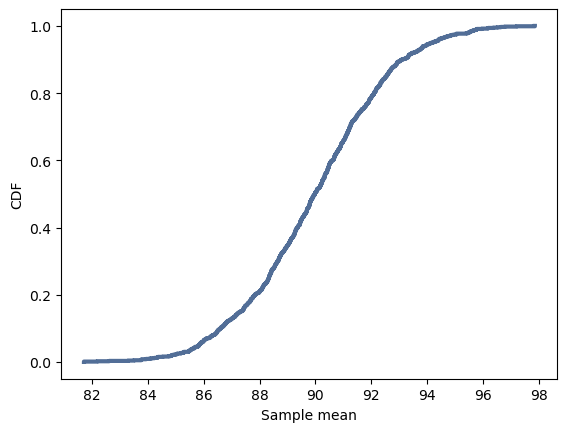

In [49]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

In [50]:
np.mean(xbars)

89.97149325814543

In [51]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(85.82825303775884, 94.1580514641571)

In [52]:
stderr = RMSE(xbars, 90)
stderr

2.526239168588642

In [53]:
def Estimate3(n=7, iters=1000):
    lam = 2

    Ls = []
    Lms = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        Ls.append(L)
        Lms.append(Lm)

    print('rmse L', RMSE(Ls, lam))
    print('rmse Lm', RMSE(Lms, lam))
    print('mean error L', MeanError(Ls, lam))
    print('mean error Lm', MeanError(Lms, lam))
    
Estimate3()

rmse L 1.0976679401098943
rmse Lm 1.8959495826563926
mean error L 0.36328823610733196
mean error Lm 0.5047904938174527


# Exercises

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [93]:
import random
import numpy as np

def MeanError(estimates, true_value):
    return np.mean(estimates) - true_value

def MSE(estimates, true_value):
    return np.mean((np.array(estimates) - true_value) ** 2)

def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1
    true_variance = sigma ** 2

    means = []
    medians = []
    s2_values = []
    s_n_minus_1_squared = []

    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        
        # Calculate mean and median
        xbar = np.mean(xs)
        median = np.median(xs)

        # Variance estimates
        s2 = np.var(xs)  # Population variance estimate (biased)
        s_n_minus_1 = np.var(xs, ddof=1)  # Sample variance estimate (unbiased)

        means.append(xbar)
        medians.append(median)
        s2_values.append(s2)
        s_n_minus_1_squared.append(s_n_minus_1)

    print("Experiment 2")
    print(f"Mean Error of \u03bc (xbar): {MeanError(means, mu):.4f}")
    print(f"Mean Error of \u03bc (median): {MeanError(medians, mu):.4f}")
    print(f"MSE of \u03bc (xbar): {MSE(means, mu):.4f}")
    print(f"MSE of \u03bc (median): {MSE(medians, mu):.4f}")

    print(f"Mean Error of \u03c3^2 (S^2): {MeanError(s2_values, true_variance):.4f}")
    print(f"Mean Error of \u03c3^2 (S_n-1^2): {MeanError(s_n_minus_1_squared, true_variance):.4f}")
    print(f"MSE of \u03c3^2 (S^2): {MSE(s2_values, true_variance):.4f}")
    print(f"MSE of \u03c3^2 (S_n-1^2): {MSE(s_n_minus_1_squared, true_variance):.4f}")

# Run the extended experiment
Estimate2()


Experiment 2
Mean Error of μ (xbar): 0.0110
Mean Error of μ (median): 0.0149
MSE of μ (xbar): 0.1458
MSE of μ (median): 0.2121
Mean Error of σ^2 (S^2): -0.1243
Mean Error of σ^2 (S_n-1^2): 0.0217
MSE of σ^2 (S^2): 0.2938
MSE of σ^2 (S_n-1^2): 0.3793


Neither xbar or median seem to be clearly biased, however xbar seems to be consistently less biased.
$S_{n-1}^2$ yields a loswer MSE.

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



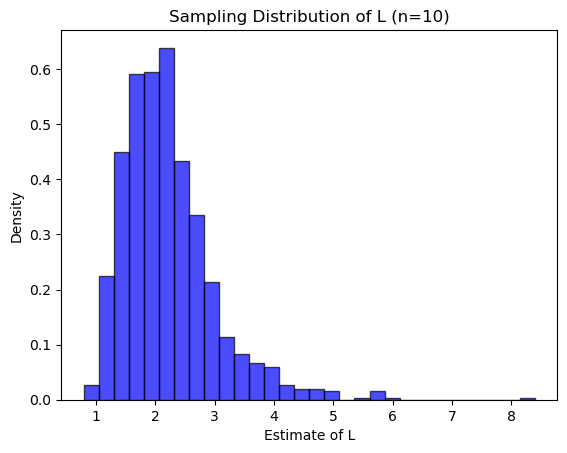

Standard Error of Estimate (n=10): 0.7883580956761624
90% Confidence Interval (n=10): (1.2435324202829514, 3.699404050745532)


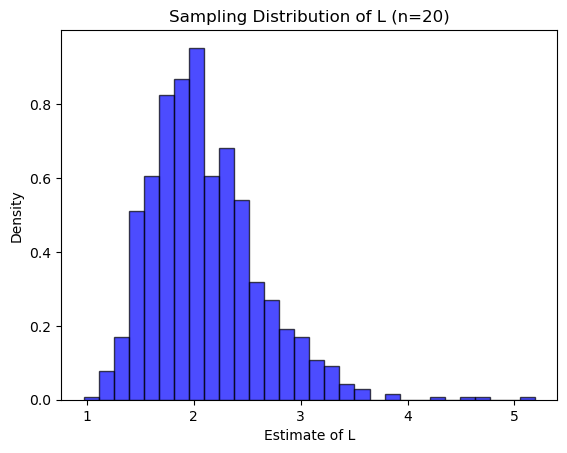

Standard Error of Estimate (n=20): 0.5086179027499506
90% Confidence Interval (n=20): (1.4380236044160046, 3.0531092057887808)


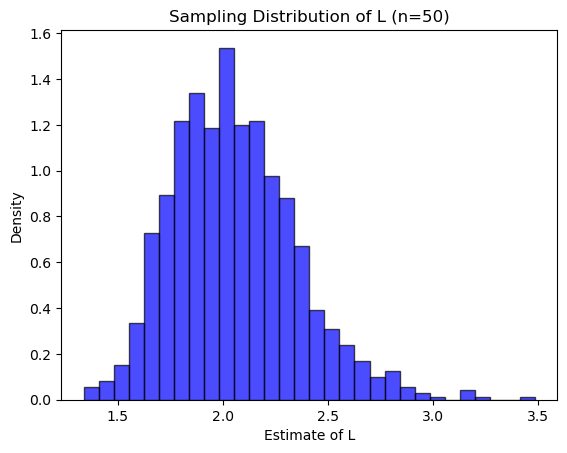

Standard Error of Estimate (n=50): 0.29622360148972204
90% Confidence Interval (n=50): (1.6301388552199785, 2.571429754862648)


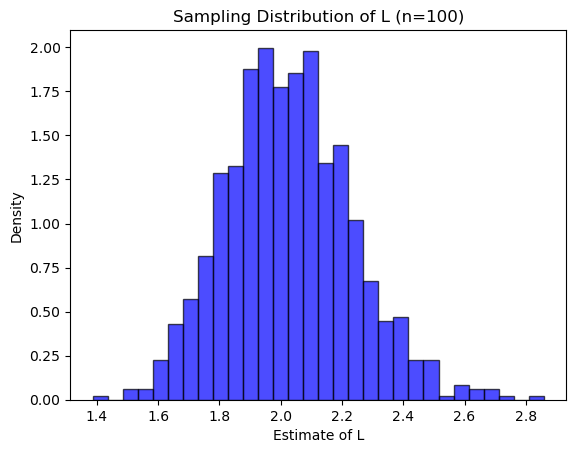

Standard Error of Estimate (n=100): 0.20686425414466086
90% Confidence Interval (n=100): (1.7042905424581334, 2.381298451251939)


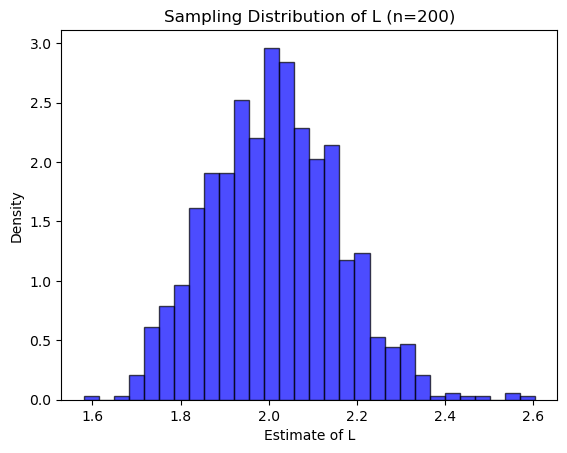

Standard Error of Estimate (n=200): 0.1453321708371903
90% Confidence Interval (n=200): (1.7790406023894165, 2.2570690319499223)


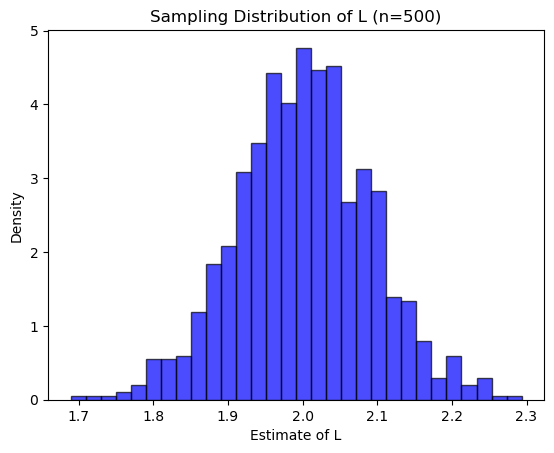

Standard Error of Estimate (n=500): 0.08930114437537932
90% Confidence Interval (n=500): (1.859008660975699, 2.148946757724173)


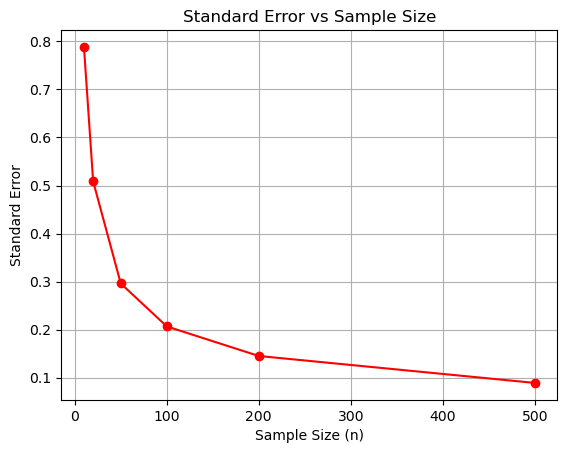

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def Estimate3(n=10, iters=1000):
    lam = 2
    
    # Simulate the experiment
    estimates = []
    for _ in range(iters):
        sample = np.random.exponential(scale=1/lam, size=n)  # Exponential distribution with lambda=2
        L_hat = 1 / np.mean(sample)  # Estimate of lambda (L)
        estimates.append(L_hat)

    # Compute standard error
    se = np.std(estimates, ddof=1)

    # Compute 90% confidence interval
    ci_lower = np.percentile(estimates, 5)  # 5th percentile
    ci_upper = np.percentile(estimates, 95)  # 95th percentile

    # Plot the sampling distribution
    plt.hist(estimates, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Sampling Distribution of L (n={n})")
    plt.xlabel("Estimate of L")
    plt.ylabel("Density")
    plt.show()

    print(f"Standard Error of Estimate (n={n}): {se}")
    print(f"90% Confidence Interval (n={n}): ({ci_lower}, {ci_upper})")
    return se

# Repeat the experiment with different values of n and plot standard error vs n
n_values = [10, 20, 50, 100, 200, 500]
standard_errors = []

for n in n_values:
    se = Estimate3(n=n, iters=1000)
    standard_errors.append(se)

# Plot standard error vs n
plt.figure()
plt.plot(n_values, standard_errors, marker='o', linestyle='-', color='red')
plt.title("Standard Error vs Sample Size")
plt.xlabel("Sample Size (n)")
plt.ylabel("Standard Error")
plt.grid(True)
plt.show()
